<a href="https://colab.research.google.com/github/MarioPulpo95/DMDAS/blob/main/DenseDepthNewDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Nunzio03/DenseDepth_eval01

Cloning into 'DenseDepth_eval01'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 402 (delta 48), reused 66 (delta 21), pack-reused 298
Receiving objects: 100% (402/402), 15.42 MiB | 24.52 MiB/s, done.
Resolving deltas: 100% (198/198), done.


In [2]:
!wget https://cvg.cit.tum.de/rgbd/dataset/freiburg1/rgbd_dataset_freiburg1_xyz.tgz

--2023-05-30 08:22:31--  https://cvg.cit.tum.de/rgbd/dataset/freiburg1/rgbd_dataset_freiburg1_xyz.tgz
Resolving cvg.cit.tum.de (cvg.cit.tum.de)... 131.159.19.110, 2a09:80c0:18::1110
Connecting to cvg.cit.tum.de (cvg.cit.tum.de)|131.159.19.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 448204271 (427M) [application/x-gzip]
Saving to: ‘rgbd_dataset_freiburg1_xyz.tgz’

rgbd_dataset_freibu 100%[===================>] 427.44M  24.1MB/s    in 19s     

2023-05-30 08:22:51 (22.1 MB/s) - ‘rgbd_dataset_freiburg1_xyz.tgz’ saved [448204271/448204271]



In [3]:
!tar xf rgbd_dataset_freiburg1_xyz.tgz

# DIFFERENZA TRA I MODELLI 
I modelli KITTI e NYU sono due diversi dataset utilizzati per la predizione delle immagini di profondità.

KITTI è un dataset ampiamente utilizzato per la visione artificiale, specificamente per il campo dell'automazione dei veicoli. Contiene immagini acquisite da una macchina fotografica montata su un veicolo in movimento lungo strade urbane. Le immagini sono state catturate in diverse condizioni di luce e di tempo, e includono anche immagini di profondità acquisite con un sensore LiDAR (Light Detection and Ranging). Il dataset KITTI comprende sia immagini RGB che immagini di profondità, rendendolo adatto per l'addestramento e la valutazione di modelli di predizione di profondità.

NYU Depth Dataset è un altro dataset molto utilizzato per la predizione delle immagini di profondità. Questo dataset è stato creato utilizzando una fotocamera RGB-D (Red Green Blue - Depth) montata su un braccio robotico in ambienti interni. Le immagini RGB-D sono state acquisite in diverse stanze con oggetti di diverse forme e dimensioni. Il dataset NYU contiene immagini RGB e corrispondenti mappe di profondità ad alta risoluzione, consentendo l'addestramento e la valutazione dei modelli di predizione di profondità.

Entrambi i dataset sono utilizzati per l'addestramento e la valutazione dei modelli di apprendimento automatico che mirano a prevedere la profondità delle immagini a partire dalle immagini RGB. Tuttavia, i due dataset differiscono per quanto riguarda l'ambiente di acquisizione (urbano vs. interno), il tipo di sensori utilizzati (LiDAR vs. fotocamera RGB-D) e le condizioni di illuminazione. La scelta del dataset dipenderà dall'applicazione specifica e dalle condizioni in cui si desidera utilizzare il modello di predizione di profondità.

In [4]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O ./DenseDepth_eval01/nyu.h5
!wget https://s3-eu-west-1.amazonaws.com/densedepth/kitti.h5 -O ./DenseDepth_eval01/kitti.h5

--2023-05-30 08:23:02--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.60.67, 52.218.40.147, 52.218.24.91, ...
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.60.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘./DenseDepth_eval01/nyu.h5’

./DenseDepth_eval01 100%[===================>] 164.89M  27.2MB/s    in 6.9s    

2023-05-30 08:23:10 (23.9 MB/s) - ‘./DenseDepth_eval01/nyu.h5’ saved [172897376/172897376]

--2023-05-30 08:23:10--  https://s3-eu-west-1.amazonaws.com/densedepth/kitti.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.65.100, 52.92.36.136, 52.218.96.186, ...
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.65.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897384 (165M) [application/x-www-form-urlen

In [5]:
import os
import glob
import argparse
import matplotlib
import cv2

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from DenseDepth_eval01.layers import BilinearUpSampling2D
from tensorflow.keras.layers import Layer, InputSpec
from DenseDepth_eval01.utils import predict, load_images, display_images
from matplotlib import pyplot as plt
from DenseDepth_eval01.validation_metrics import mean_absolute_error, root_mean_squared_error, relative_absolute_error, relative_squared_error,  accuracy,ssim,normalized_median_error, gradient_error, mean_squared_error
from scipy.ndimage import zoom
import numpy as np
import cv2

rgb_file = 'rgbd_dataset_freiburg1_xyz/rgb.txt'
depth_file = 'rgbd_dataset_freiburg1_xyz/depth.txt'

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load models into GPU / CPU
model_nyu = load_model('DenseDepth_eval01/nyu.h5', custom_objects=custom_objects, compile=False)
model_kitti = load_model('DenseDepth_eval01/kitti.h5', custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format('DenseDepth_eval01/nyu.h5'))
print('\nModel loaded ({0}).'.format('DenseDepth_eval01/kitti.h5'))

# Read the RGB and depth file paths from the text files
with open(rgb_file, 'r') as rgb_f, open(depth_file, 'r') as depth_f:
    rgb_paths = [line.strip().split()[1] for line in rgb_f][3:24]
    depth_paths = [line.strip().split()[1] for line in depth_f][3:24]

rgb_imgs=[]
depth_imgs=[]

# Load the RGB and depth images
for rgb_path, depth_path in zip(rgb_paths, depth_paths):
    rgb_image = cv2.imread("rgbd_dataset_freiburg1_xyz/"+rgb_path)
    depth_image = cv2.imread("rgbd_dataset_freiburg1_xyz/"+depth_path)
    
    rgb_imgs.append(rgb_image)
    depth_imgs.append(depth_image)

rgb_imgs = np.array(rgb_imgs)
depth_imgs = np.array(depth_imgs)


Loading model...

Model loaded (DenseDepth_eval01/nyu.h5).

Model loaded (DenseDepth_eval01/kitti.h5).


In [6]:
# prediction of depth images
inputs = rgb_imgs
outputs_nyu = predict(model_nyu, inputs)
outputs_kitti = predict(model_kitti, inputs)

# zoom output images in order to meet the ground truth images shape (480,640)
outputs_nyu = zoom(outputs_nyu, (1, 2, 2, 1))
outputs_kitti = zoom(outputs_kitti, (1, 2, 2, 1))


11/11 [==============================] - 114s 10s/step


In [7]:
# ground truth images 
gtdepth = depth_imgs
preddepth_nyu = outputs_nyu
preddepth_kitti = outputs_kitti

#print(preddepth.shape)  
#print(gtdepth.shape)   

# squeeze the predictions to remove extra dimension
preddepth_nyu = np.squeeze(preddepth_nyu, axis=-1)
preddepth_kitti = np.squeeze(preddepth_kitti, axis=-1)
gtdepth = np.mean(gtdepth, axis=-1)

#print(preddepth.shape)  
#print(gtdepth.shape)  

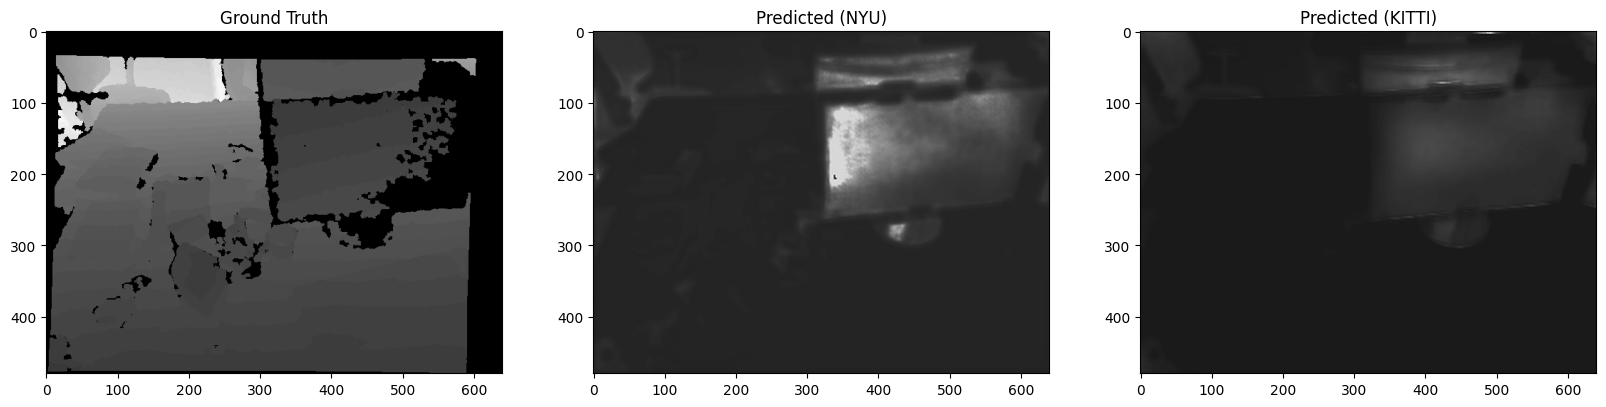

In [14]:
# plot gt and the predicted depth of both models
index_to_check = 5
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
plt.imshow(gtdepth[index_to_check], cmap='gray')
plt.title('Ground Truth')
plt.subplot(1,3,2)
plt.imshow(preddepth_nyu[index_to_check], cmap='gray')
plt.title('Predicted (NYU)')
plt.subplot(1,3,3)
plt.imshow(preddepth_kitti[index_to_check], cmap='gray')
plt.title('Predicted (KITTI)')
plt.show()


In [15]:
# models validation
nyu_mae_sum = 0.0
nyu_mse_sum = 0.0
nyu_ssim_sum = 0.0
nyu_rmse_sum = 0.0
nyu_rae_sum = 0.0
nyu_rse_sum = 0.0
nyu_nme_sum = 0.0
nyu_num_images = len(preddepth_nyu)

kitti_mae_sum = 0.0
kitti_mse_sum = 0.0
kitti_ssim_sum = 0.0
kitti_rmse_sum = 0.0
kitti_rae_sum = 0.0
kitti_rse_sum = 0.0
kitti_nme_sum = 0.0
kitti_num_images = len(preddepth_kitti)


for img_out, img_gt in zip(preddepth_nyu, gtdepth):
    # nyu metrics
    NYU_MAE = mean_absolute_error(img_out, img_gt)
    NYU_MSE = mean_squared_error(img_out, img_gt)
    NYU_SSIM = ssim(img_out, img_gt)
    NYU_RMSE = root_mean_squared_error(img_out, img_gt)
    NYU_RAE = relative_absolute_error(img_out, img_gt)
    NYU_RSE = relative_squared_error(img_out, img_gt)
    NYU_NME = normalized_median_error(img_out, img_gt)

    if np.mean(img_gt) != 0.0:
        nyu_mae_sum += sum(NYU_MAE) / len(NYU_MAE)
        nyu_mse_sum += sum(NYU_MSE) / len(NYU_MSE)
        nyu_ssim_sum += sum(NYU_SSIM) / len(NYU_SSIM)
        nyu_rmse_sum += sum(NYU_RMSE) / len(NYU_RMSE)
        nyu_rae_sum += sum(NYU_RAE) / len(NYU_RAE)
        nyu_rse_sum += sum(NYU_RSE) / len(NYU_RSE)

    else:
        nyu_mae_sum = 0
        nyu_mse_sum = 0
        nyu_ssim_sum = 0
        nyu_rmse_sum = 0
        nyu_rae_sum = 0
        nyu_rse_sum = 0
        nyu_nme_sum = 0


for img_out, img_gt in zip(preddepth_kitti, gtdepth):
    # kitti metrics
    KITTI_MAE = mean_absolute_error(img_out, img_gt)
    KITTI_MSE = mean_squared_error(img_out, img_gt)
    KITTI_SSIM = ssim(img_out, img_gt)
    KITTI_RMSE = root_mean_squared_error(img_out, img_gt)
    KITTI_RAE = relative_absolute_error(img_out, img_gt)
    KITTI_RSE = relative_squared_error(img_out, img_gt)
    KITTI_NME = normalized_median_error(img_out, img_gt)

    if np.mean(img_gt) != 0.0:
        kitti_mae_sum += sum(KITTI_MAE) / len(KITTI_MAE)
        kitti_mse_sum += sum(KITTI_MSE) / len(KITTI_MSE)
        kitti_ssim_sum += sum(KITTI_SSIM) / len(KITTI_SSIM)
        kitti_rmse_sum += sum(KITTI_RMSE) / len(KITTI_RMSE)
        kitti_rae_sum += sum(KITTI_RAE) / len(KITTI_RAE)
        kitti_rse_sum += sum(KITTI_RSE) / len(KITTI_RSE)
        kitti_nme_sum += sum(KITTI_NME) / len(KITTI_NME)
    else: 
        kitti_mae_sum = 0
        kitti_mse_sum = 0
        kitti_ssim_sum = 0
        kitti_rmse_sum = 0
        kitti_rae_sum = 0
        kitti_rse_sum = 0
        kitti_nme_sum = 0

# nyu mean values
nyu_mean_mae = nyu_mae_sum / nyu_num_images
nyu_mean_mse = nyu_mse_sum / nyu_num_images
nyu_mean_ssim = nyu_ssim_sum / nyu_num_images
nyu_mean_rmse = nyu_rmse_sum / nyu_num_images
nyu_mean_rae = nyu_rae_sum / nyu_num_images
nyu_mean_rse = nyu_rse_sum / nyu_num_images
nyu_mean_nme = nyu_nme_sum / nyu_num_images

# kitti mean values
kitti_mean_mae = kitti_mae_sum / kitti_num_images
kitti_mean_mse = kitti_mse_sum / kitti_num_images
kitti_mean_ssim = kitti_ssim_sum / kitti_num_images
kitti_mean_rmse = kitti_rmse_sum / kitti_num_images
kitti_mean_rae = kitti_rae_sum / kitti_num_images
kitti_mean_rse = kitti_rse_sum / kitti_num_images
kitti_mean_nme = kitti_nme_sum / kitti_num_images

print("NYU Dataset:")
print("Mean Absolute Error:", nyu_mean_mae)
print("Structural Similarity Index:", nyu_mean_ssim)
print("Mean Squared Error:", nyu_mean_mse)
print("Relative Absolute Error:", nyu_mean_rae)
print("Relative Squared Error:", nyu_mean_rse)
print("Root Mean Squared Error:", nyu_mean_rmse)
print("Normalized Median Error:", nyu_mean_nme)

print("KITTI Dataset:")
print("Mean Absolute Error:", kitti_mean_mae)
print("Structural Similarity Index:", kitti_mean_ssim)
print("Mean Squared Error:", kitti_mean_mse)
print("Relative Absolute Error:", kitti_mean_rae)
print("Relative Squared Error:", kitti_mean_rse)
print("Root Mean Squared Error:", kitti_mean_rmse)
print("Normalized Median Error:", kitti_mean_nme)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
/content/DenseDepth_eval01/validation_metrics.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  error_score = average_absolute_diff / np.mean(gt_depth)
/content/DenseDepth_eval01/validation_metrics.py:79: RuntimeWarning: divide by zero encountered in double_scalars
  error_score = average_squared_diff / np.mean(gt_depth**2)
/content/DenseDepth_eval01/validation_metrics.py:127: RuntimeWarning: divide by zero encountered in double_scalars
  nme_score = median_diff / median_gt


NYU Dataset:
Mean Absolute Error: 16.65545647087651
Structural Similarity Index: 0.050871971647810196
Mean Squared Error: 436.11448674891204
Relative Absolute Error: inf
Relative Squared Error: inf
Root Mean Squared Error: 19.237689912726363
Normalized Median Error: 0.0
KITTI Dataset:
Mean Absolute Error: 16.68878833752178
Structural Similarity Index: 0.1017308194955184
Mean Squared Error: 437.9961370429959
Relative Absolute Error: inf
Relative Squared Error: inf
Root Mean Squared Error: 19.274201231865145
Normalized Median Error: inf


# METRICA SSIM
La metrica SSIM (Structural Similarity Index) è una misura di similarità strutturale tra due immagini. Viene spesso utilizzata per valutare la qualità delle immagini o per confrontare due immagini per la loro somiglianza strutturale.
Considera tre componenti principali per valutare la similarità strutturale tra due immagini: luminanza, contrasto e struttura. Queste componenti riflettono le proprietà percettive dell'immagine e vengono combinati per calcolare un indice SSIM complessivo.
Il calcolo dell'indice SSIM coinvolge diverse operazioni. Innanzitutto, le immagini di input vengono suddivise in piccoli blocchi. Per ogni blocco, vengono calcolate la media della luminanza, la deviazione standard della luminanza e la covarianza tra le due immagini. Queste statistiche vengono quindi utilizzate per calcolare la similarità per ogni blocco.
Infine, viene calcolato un indice SSIM medio combinando i valori di similarità ottenuti per i vari blocchi. L'indice SSIM varia da 0 a 1, dove 1 rappresenta una perfetta similarità strutturale tra le immagini.
Può essere utilizzato per confrontare la qualità di diverse versioni di un'immagine (ad esempio, l'originale e una compressa) o per valutare l'effetto di filtri o algoritmi di elaborazione dell'immagine.

In [16]:
# compare nyu and kitti metrics
print("Confronto tra NYU e KITTI:")
print("Mean Absolute Error:")
if nyu_mean_mae < kitti_mean_mae:
    print("NYU ha un MAE inferiore a KITTI")
elif nyu_mean_mae > kitti_mean_mae:
    print("NYU ha un MAE superiore a KITTI")
else:
    print("NYU e KITTI hanno lo stesso MAE")

print("Structural Similarity Index:")
if nyu_mean_ssim > kitti_mean_ssim:
    print("NYU ha un SSIM superiore a KITTI")
elif nyu_mean_ssim < kitti_mean_ssim:
    print("NYU ha un SSIM inferiore a KITTI")
else:
    print("NYU e KITTI hanno lo stesso SSIM")

print("Mean Squared Error:")
if nyu_mean_mse < kitti_mean_mse:
    print("NYU ha un MSE inferiore a KITTI")
elif nyu_mean_mse > kitti_mean_mse:
    print("NYU ha un MSE superiore a KITTI")
else:
    print("NYU e KITTI hanno lo stesso MSE")

print("Root Mean Squared Error:")
if nyu_mean_rmse < kitti_mean_rmse:
    print("NYU ha un RMSE inferiore a KITTI")
elif nyu_mean_rmse > kitti_mean_rmse:
    print("NYU ha un RMSE superiore a KITTI")
else:
    print("NYU e KITTI hanno lo stesso RMSE")

print("Normalized Median Error:")
if nyu_mean_nme < kitti_mean_nme:
    print("NYU ha un NME inferiore a KITTI")
elif nyu_mean_nme > kitti_mean_nme:
    print("NYU ha un NME superiore a KITTI")
else:
    print("NYU e KITTI hanno lo stesso NME")


print("Relative Absolute Error:")
if nyu_mean_rae > kitti_mean_rae:
    print("NYU ha un RAE superiore a KITTI")
elif nyu_mean_rae < kitti_mean_rae:
    print("NYU ha un RAE inferiore a KITTI")
else:
    print("NYU e KITTI hanno lo stesso RAE")

print("Relative Squared Error:")
if nyu_mean_rse > kitti_mean_rse:
    print("NYU ha un RSE superiore a KITTI")
elif nyu_mean_rse < kitti_mean_rse:
    print("NYU ha un RSE inferiore a KITTI")
else:
    print("NYU e KITTI hanno lo stesso RSE")


Confronto tra NYU e KITTI:
Mean Absolute Error:
NYU ha un MAE inferiore a KITTI
Structural Similarity Index:
NYU ha un SSIM inferiore a KITTI
Mean Squared Error:
NYU ha un MSE inferiore a KITTI
Root Mean Squared Error:
NYU ha un RMSE inferiore a KITTI
Normalized Median Error:
NYU ha un NME inferiore a KITTI
Relative Absolute Error:
NYU e KITTI hanno lo stesso RAE
Relative Squared Error:
NYU e KITTI hanno lo stesso RSE
